In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from collections import deque
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

## Loading Dataset

In [3]:
def load_data():
    df = pd.read_csv("data/btc_usd_charts.csv", sep=";")
    return df

In [4]:
def transform_data(df):
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df.sort_values(by=["open_time"], ascending="True", inplace=True)
    df.set_index("open_time", inplace=True)
    df = df.resample("D")
    df = df.first()
    return df

In [5]:
df = load_data()
df = transform_data(df)

In [6]:
df = df[(int(len(df)/2)):]

In [7]:
df.describe()

,open
count,650.000000
mean,13453.500385
std,10111.939958
min,4800.010000
25%,8575.210000
50%,9778.565000
75%,11756.500000
max,57412.400000


## Splitting Data into a train and test set

In [8]:
def split_data(df, lookup_step=1, n_steps=7, split_size=0.2):
    result = {}
    result["df"] = df.copy()
    df["open_time"] = df.index

    # scaling the data from 0 to 1
    scaler = preprocessing.MinMaxScaler()
    df["open"] = scaler.fit_transform(np.expand_dims(df["open"].values, axis = 1))
    result["scaler"] = scaler
    
    # shifting the target column values by `lookup_step`
    df["future"] = df["open"].shift(-lookup_step)
    last_sequence = np.array(df["open"].tail(lookup_step))
    result["last_sequence"] = last_sequence
    df.dropna(inplace=True)

    # creating sequences of data
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[["open"] + ["open_time"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)

    # splitting by `split_size`
    train_samples = int((1 - split_size * len(X)))
    X_train = X[:train_samples]
    y_train = y[:train_samples]
    X_test = X[train_samples:]
    y_test = y[train_samples:]

    
    result["X_train"] = X_train
    result["y_train"] = y_train
    result["X_test"] = X_test
    result["y_test"] = y_test

    dates = result["X_test"][:, -1, -1]
    result["test_df"] = result["df"].loc[dates]
    result["X_train"] = result["X_train"][:, :, :1].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :1].astype(np.float32)
    return result

In [9]:
data = split_data(df)

## Creating the Model

In [10]:
def create_model(sequence_length, n_features=1, units=16, cell=LSTM, n_layers=2, dropout=0.4, loss="huber_loss", optimizer="adam", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(7, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


In [11]:
model = create_model(sequence_length=7, cell=LSTM)
history = model.fit(data["X_train"], data["y_train"], batch_size=64 , epochs=300 , validation_data=(data["X_test"], data["y_test"]), verbose=0)

In [12]:
model.evaluate(data["X_test"], data["y_test"], verbose=0) #loss, mae

[0.0012662338558584452, 0.03981780260801315]

## Model Evaluation

In [13]:
def evaluation(model, data):
    loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
    y_pred = model.predict(data["X_test"])
    y_test = np.squeeze(data["scaler"].inverse_transform(np.expand_dims(data["y_test"], axis=0)))
    y_pred = np.squeeze(data["scaler"].inverse_transform(y_pred)) # bislang noch keine X/Y Zuordnung
    test_df = data["test_df"]
    test_df["y_test"] = y_test
    return test_df, y_pred, loss, mae

In [14]:
def predictions_shifting(final_df, predictions):
    predictions = pd.DataFrame(predictions)
    i = 0
    for column in predictions:
        predictions[column] = predictions[column].shift(i)
        i += 1
    df = final_df.reset_index().join(predictions).set_index("open_time")
    return df

In [15]:
final_df, predictions, loss, mae = evaluation(model, data)
final_df = predictions_shifting(final_df, predictions)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


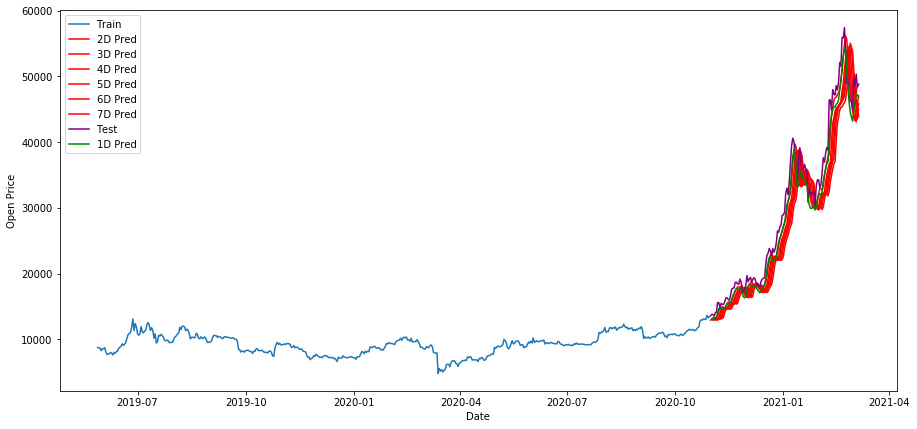

In [16]:
plt.figure(figsize=(15,7))
plt.plot(data["df"].iloc[:-(len(final_df) + 1)]["open"]) # train data
plt.plot(final_df[[1, 2, 3, 4, 5, 6]], color="red") # predicted prices
plt.plot(final_df["open"], color="purple") # test data
plt.plot(final_df[0], color="green")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend(["Train", "2D Pred", "3D Pred", "4D Pred", "5D Pred", "6D Pred", "7D Pred", "Test", "1D Pred"])
plt.show()

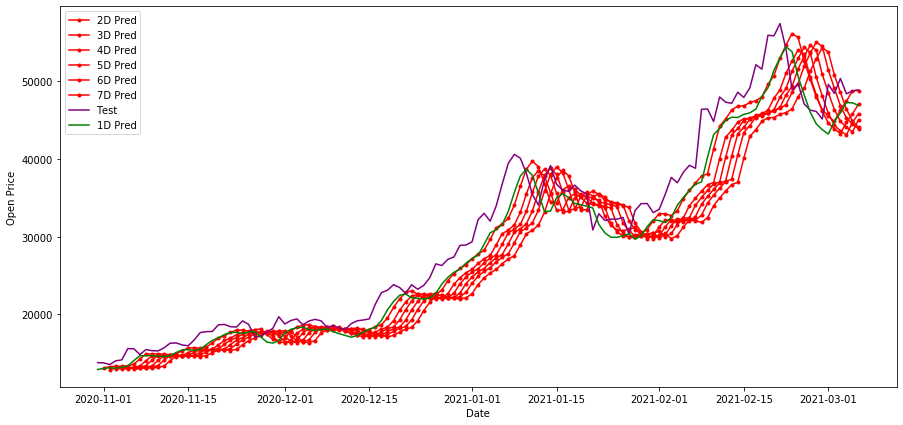

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(final_df[[1, 2, 3, 4, 5, 6]], color="red", marker="o", markersize=3) # predicted prices
plt.plot(final_df["y_test"], color="purple") # test data
plt.plot(final_df[0], color="green")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend(["2D Pred", "3D Pred", "4D Pred", "5D Pred", "6D Pred", "7D Pred", "Test", "1D Pred"])
plt.show()

In [18]:
final_df.describe()

,open,y_test,0,1,2,3,4,5,6
count,127.000000,127.000000,127.000000,126.000000,125.000000,124.000000,123.000000,122.000000,121.000000
mean,30123.237795,30401.364567,28447.296875,29051.447266,28114.492188,27998.740234,27951.583984,27961.335938,27579.621094
std,12465.271975,12486.817109,11904.000977,12331.449219,11704.618164,11639.087891,11685.453125,11740.282227,11530.963867
min,13549.600000,13549.600000,12907.076172,13119.070312,12906.260742,12944.517578,12923.833008,12976.269531,12910.999023
25%,18653.100000,18679.750000,17641.777344,17903.798828,17601.865234,17633.218750,17609.679688,17659.513672,17542.982422
50%,29331.700000,30362.200000,27610.828125,28000.195312,27137.267578,26914.556641,26657.599609,26365.365234,25772.947266
75%,38542.500000,38970.450000,35812.306641,36739.171875,35512.753906,35535.406250,35447.660156,35405.929688,35049.406250
max,57412.400000,57412.400000,54432.347656,56133.343750,54005.921875,54340.179688,54617.648438,55029.808594,54298.148438


In [19]:
final_df.head(7)

,open,y_test,0,1,2,3,4,5,6
open_time,,,,,,,,,
2020-10-31,13560.1,13791.0,12907.076172,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,13791.0,13761.5,13041.281250,13119.070312,NaN,NaN,NaN,NaN,NaN
2020-11-02,13761.5,13549.6,13130.649414,13253.088867,12906.260742,NaN,NaN,NaN,NaN
2020-11-03,13549.6,14023.5,13078.594727,13343.920898,13038.418945,12944.517578,NaN,NaN,NaN
2020-11-04,14023.5,14144.0,13190.784180,13295.640625,13128.409180,13078.657227,12923.833008,NaN,NaN
2020-11-05,14144.0,15590.0,13353.119141,13407.301758,13081.953125,13168.242188,13057.147461,12976.269531,NaN
2020-11-06,15590.0,15579.9,14059.009766,13568.025391,13191.158203,13116.499023,13147.172852,13108.221680,12910.999023


In [20]:
final_df.tail(7)

,open,y_test,0,1,2,3,4,5,6
open_time,,,,,,,,,
2021-02-28,46103.7,45134.1,43759.761719,46329.304688,46129.019531,48096.945312,50866.703125,54481.234375,54298.148438
2021-03-01,45134.1,49595.8,43197.656250,45467.128906,44623.621094,45851.691406,48540.121094,51430.781250,53761.488281
2021-03-02,49595.8,48436.6,44807.988281,44827.503906,43846.070312,44340.617188,46343.519531,49083.046875,50804.656250
2021-03-03,48436.6,50349.4,45925.472656,46317.312500,43255.210938,43612.828125,44827.656250,46846.917969,48567.289062
2021-03-04,50349.4,48374.1,47259.628906,47421.324219,44721.812500,43085.144531,44062.867188,45279.328125,46406.968750
2021-03-05,48374.1,48746.8,47207.253906,48766.156250,45779.386719,44697.500000,43480.332031,44467.289062,44871.871094
2021-03-06,48746.8,48882.2,46887.445312,48795.812500,47052.164062,45838.289062,45041.156250,43859.832031,44056.968750


In [21]:
eval_df = round(final_df.shift(1) / final_df * 100 - 100, 3)
eval_df.describe()


,open,y_test,0,1,2,3,4,5,6
count,126.000000,126.000000,126.000000,125.000000,124.000000,123.000000,122.000000,121.000000,120.000000
mean,-0.911413,-0.900325,-0.978968,-1.007488,-1.000476,-0.982463,-0.978869,-0.963033,-0.979808
std,4.442355,4.442180,2.819711,2.758437,2.735157,2.844729,2.809221,2.778225,2.755513
min,-16.343000,-16.343000,-7.985000,-7.683000,-7.673000,-7.917000,-7.880000,-7.731000,-7.721000
25%,-3.494500,-3.494500,-2.567750,-2.618000,-2.546000,-2.548000,-2.550250,-2.568000,-2.545750
50%,-0.656000,-0.604000,-1.029000,-1.042000,-1.021000,-1.029000,-1.022500,-1.007000,-1.016000
75%,1.560250,1.560250,0.526750,0.580000,0.511250,0.544000,0.510750,0.552000,0.513250
max,14.962000,14.962000,7.136000,6.947000,6.800000,7.206000,6.968000,6.902000,6.778000


In [22]:
eval_df.tail(7)

,open,y_test,0,1,2,3,4,5,6
open_time,,,,,,,,,
2021-02-28,0.376,2.148,1.712,3.519,4.655,4.997,6.152,1.007,-2.588
2021-03-01,2.148,-8.996,1.301,1.896,3.374,4.897,4.793,5.931,0.998
2021-03-02,-8.996,2.393,-3.594,1.427,1.773,3.408,4.740,4.783,5.820
2021-03-03,2.393,-3.799,-2.433,-3.217,1.366,1.669,3.382,4.773,4.607
2021-03-04,-3.799,4.083,-2.823,-2.328,-3.279,1.225,1.736,3.462,4.655
2021-03-05,4.083,-0.765,0.111,-2.758,-2.310,-3.607,1.340,1.826,3.421
2021-03-06,-0.765,-0.277,0.682,-0.061,-2.705,-2.489,-3.465,1.385,1.850


In [23]:
print("Loss: {} \nMean Absolute Error: {}".format(loss, mae))

Loss: 0.0012662338558584452 
Mean Absolute Error: 0.03981780260801315


In [24]:
# Predict the next week
data["scaler"].inverse_transform(model.predict(data["X_test"][-1:]))

array([[46887.44 , 48528.316, 46765.93 , 46820.53 , 47114.387, 47502.023,
        46945.22 ]], dtype=float32)

In [25]:
# Save model into folder ./data with the current timestemp
import datetime
ts_now = int(datetime.datetime.now().timestamp())
model_file = "results/lstm_btc_prediction_" + str(ts_now) + ".h5" 
model.save(model_file)